In [2]:
import os
import scenicplus
import scanpy as sc
import warnings
import pandas as pd
import matplotlib as mpl
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

work_dir = '/data/leuven/345/vsc34561/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'

# Loading Data

In [2]:
adata = sc.read_mtx(os.path.join(rnaseq_dir, 'snRNA_counts.mtx')).T

In [3]:
genes = pd.read_csv(os.path.join(rnaseq_dir, 'genes.csv'), sep='\t', header=None).iloc[:, -1].values
adata.var = pd.DataFrame(index=genes)

# barcodes = pd.read_csv(os.path.join(rnaseq_dir, 'barcodes_rna.csv'), sep='\t', header=None).iloc[:, -1].values
# adata.obs = pd.DataFrame(index=barcodes)

metadata = pd.read_csv(os.path.join(rnaseq_dir, 'snRNA_metadta.csv'), sep=',') #.iloc[:, -1].values
metadata.index = metadata.iloc[:,0]
metadata = metadata.rename(columns={'Unnamed: 0': 'rna_barcode'})
adata.obs = metadata

In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 61472 × 36114
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

In [22]:
adata = adata[adata.obs['celltype'] == 'MG']
adata

View of AnnData object with n_obs × n_vars = 4126 × 36114
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

# Basic Filtering

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


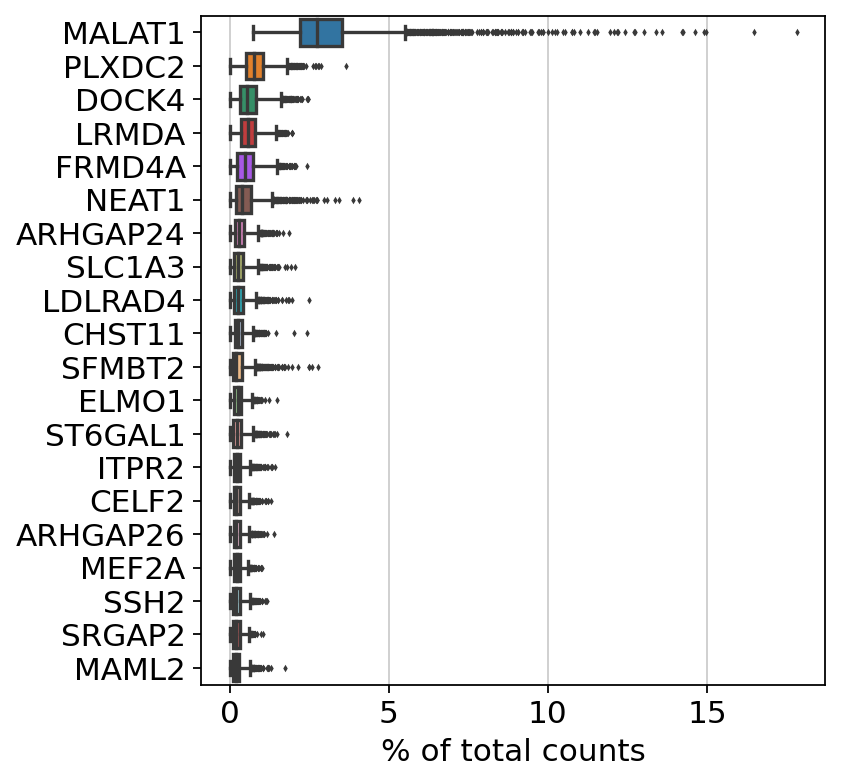

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [24]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata

AnnData object with n_obs × n_vars = 4126 × 22843
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes'
    var: 'n_cells'

In [25]:
sc.external.pp.scrublet(adata)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 5.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.0%


In [26]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 4124 × 22843
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'
    uns: 'scrublet'

In [27]:
sum(adata.var_names.str.startswith('MT-'))

0

In [28]:
sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
adata

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 4124 × 22843
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

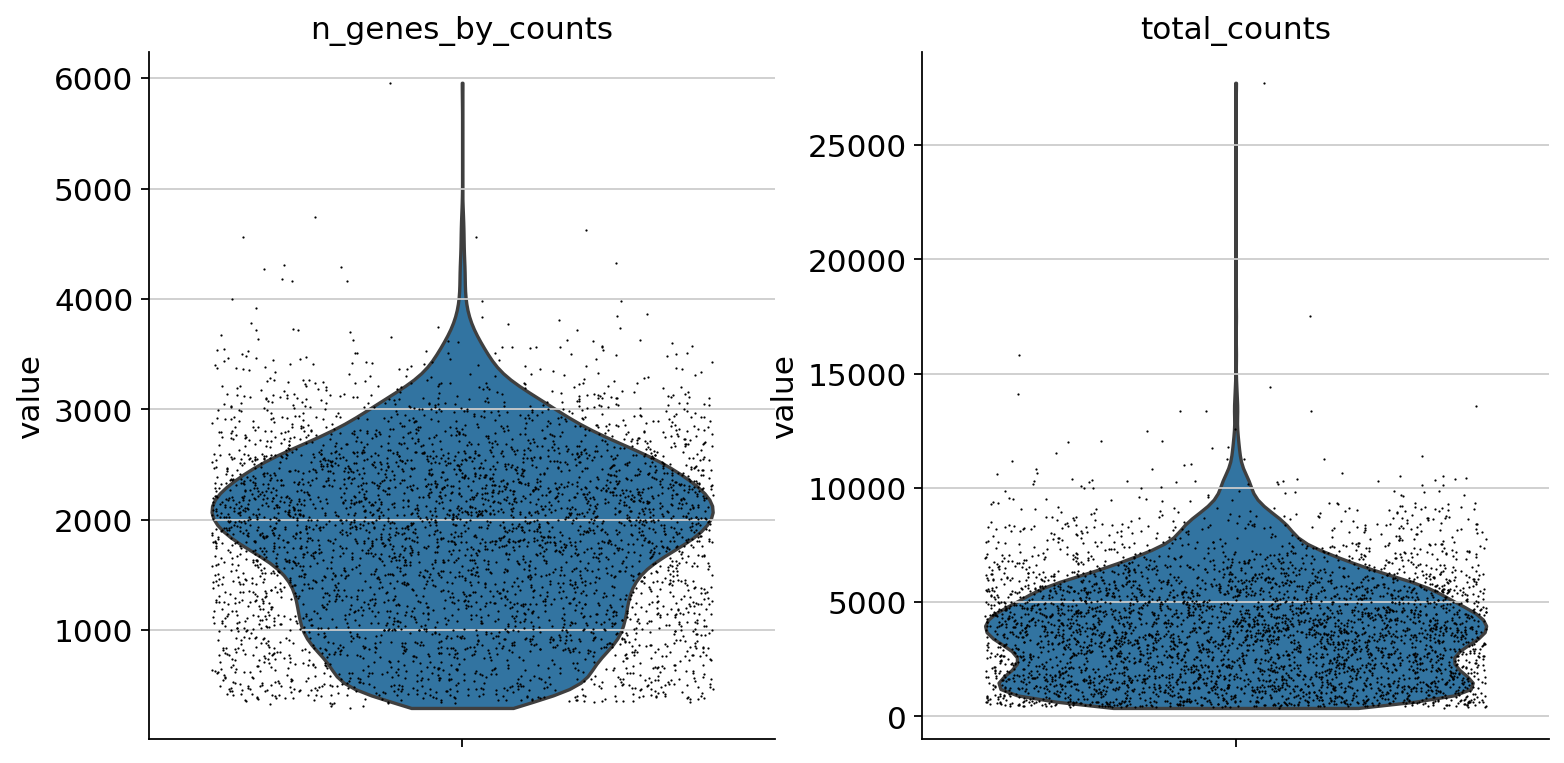

In [29]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [30]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata

View of AnnData object with n_obs × n_vars = 4111 × 22843
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [31]:
adata = adata[adata.obs.total_counts < 10000, :]
adata

View of AnnData object with n_obs × n_vars = 4071 × 22843
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

# Data Normalization

In [32]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [33]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'Batch'])
sc.pp.scale(adata, max_value=10)
adata

AnnData object with n_obs × n_vars = 4071 × 4792
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg'

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


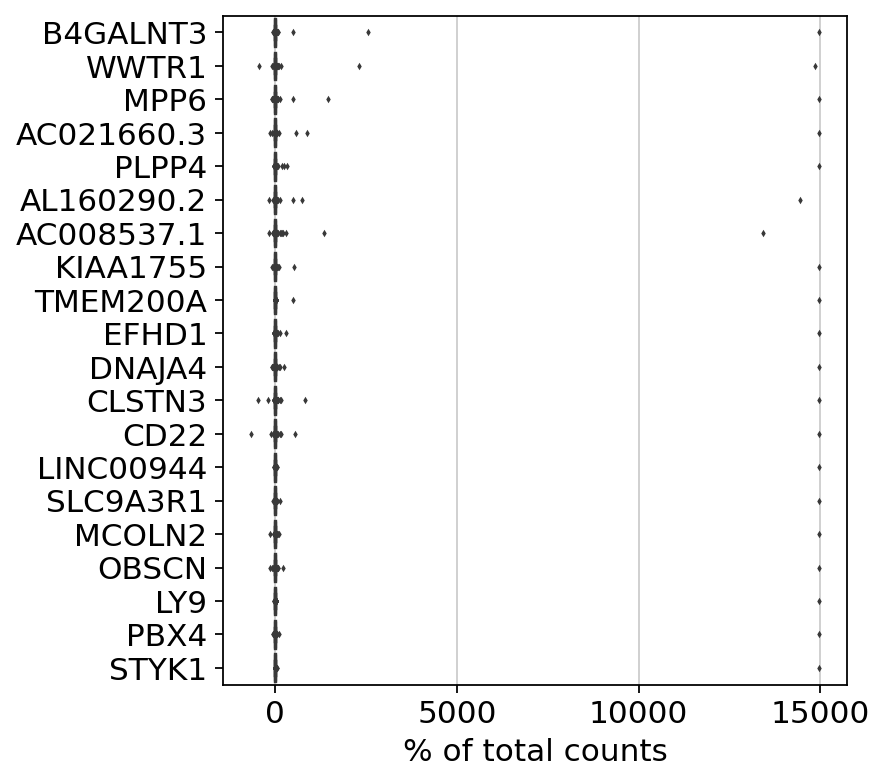

In [34]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# PCA

In [35]:
sc.tl.pca(adata, svd_solver='arpack')

In [36]:
adata

AnnData object with n_obs × n_vars = 4071 × 4792
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

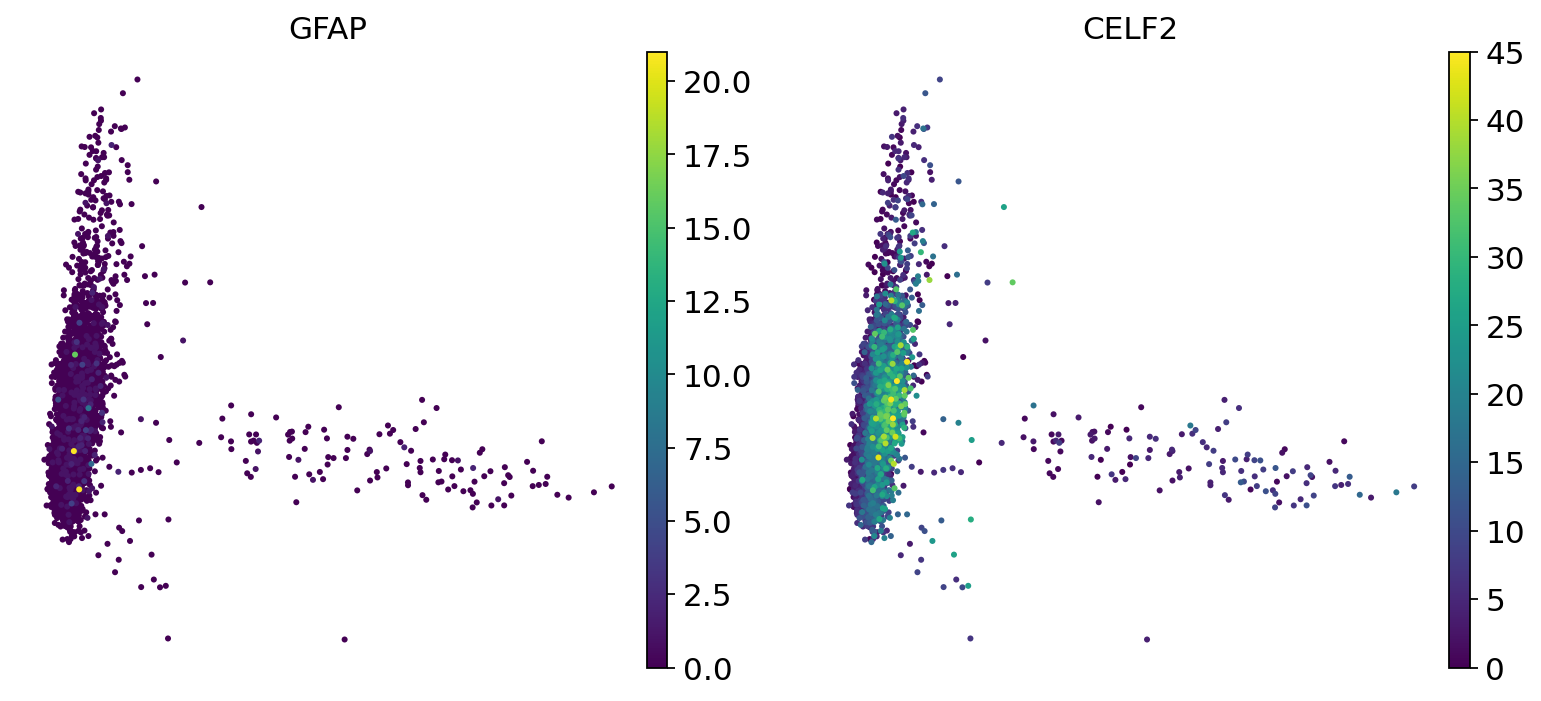

In [37]:
sc.pl.pca(adata, color=['GFAP', 'CELF2'])

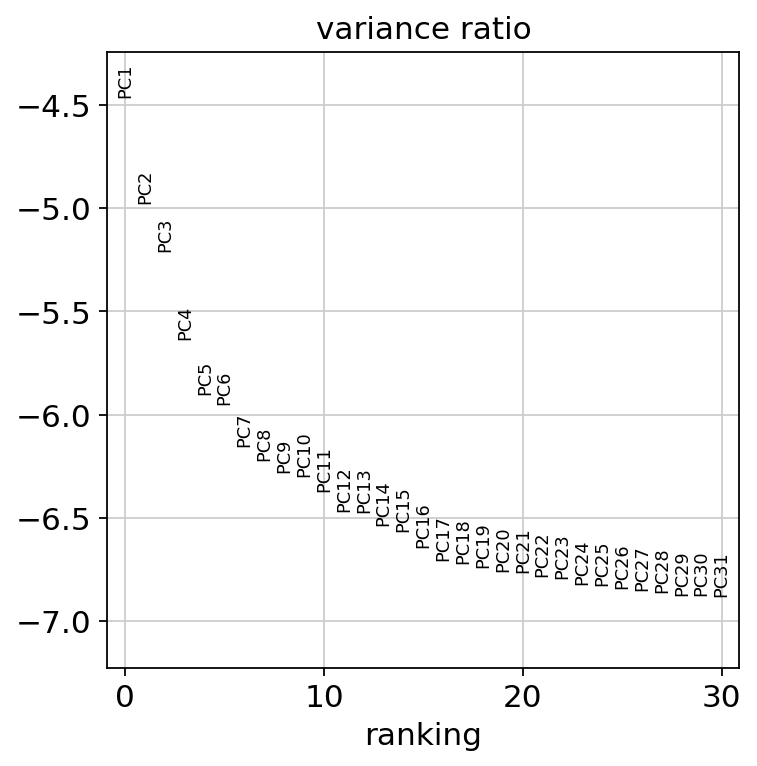

In [41]:
sc.pl.pca_variance_ratio(adata, log=True)

In [42]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

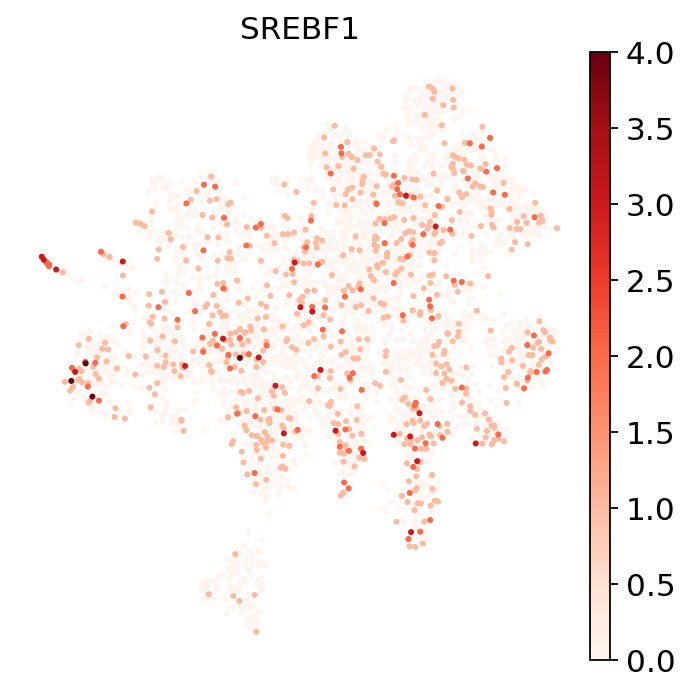

In [43]:
sc.pl.umap(adata, color=['SREBF1'], palette="Set2", color_map=mpl.cm.Reds)

In [44]:
sc.tl.leiden(adata)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


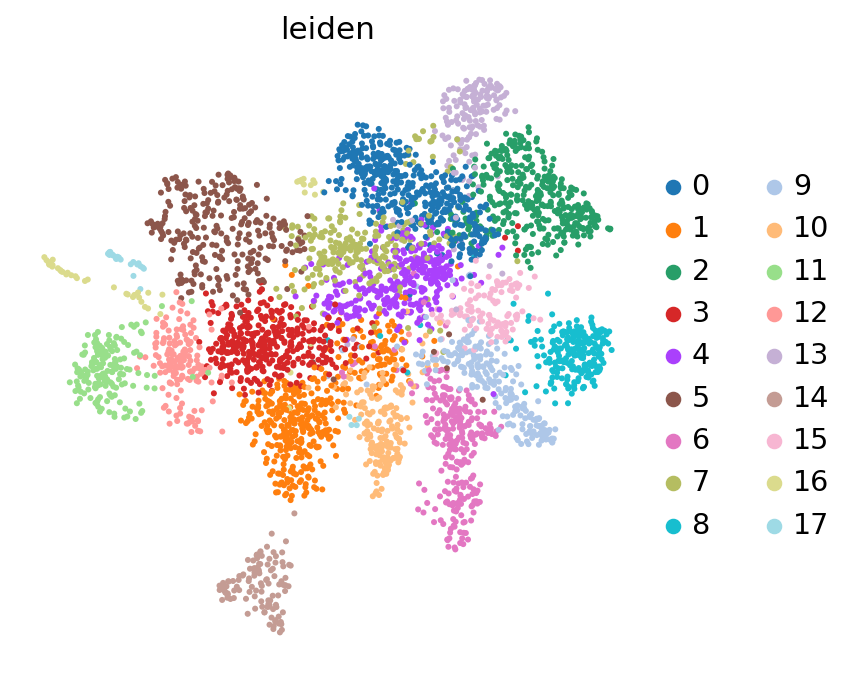

In [45]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
sc.tl.leiden(adata, resolution = 0.5, key_added = 'leiden_res_0.5')
sc.pl.umap(adata, color = 'leiden_res_0.5')

In [ ]:
sc.tl.leiden(adata, resolution = 0.2, key_added = 'leiden_res_0.2')
sc.pl.umap(adata, color = 'leiden_res_0.2')

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


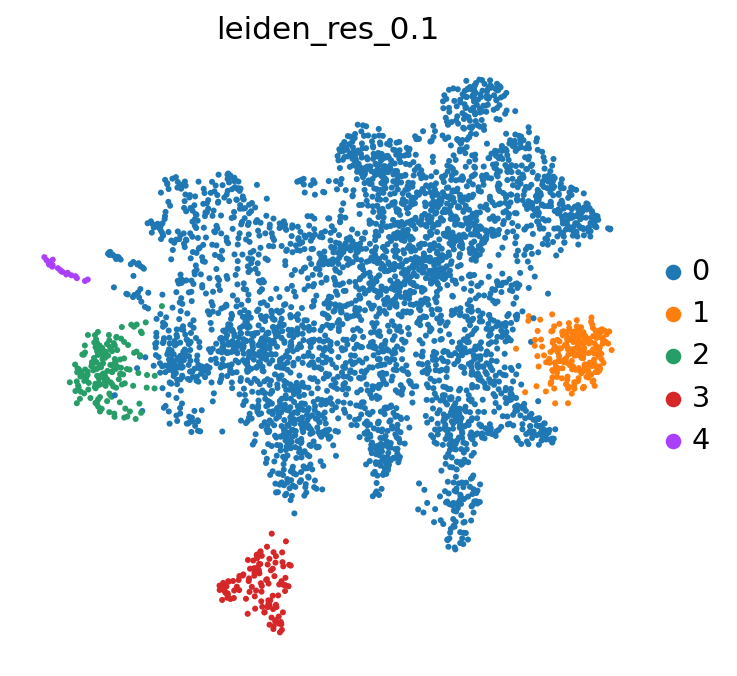

In [47]:
sc.tl.leiden(adata, resolution = 0.1, key_added = 'leiden_res_0.1')
sc.pl.umap(adata, color = 'leiden_res_0.1')

# Cell type annotation via metadata

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


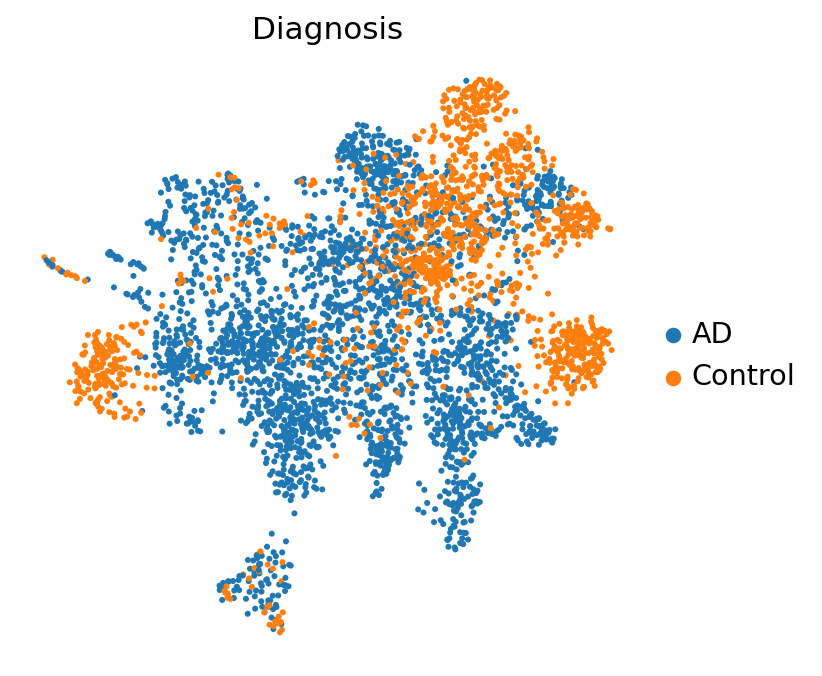

In [48]:
sc.pl.umap(adata, color='Diagnosis')

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


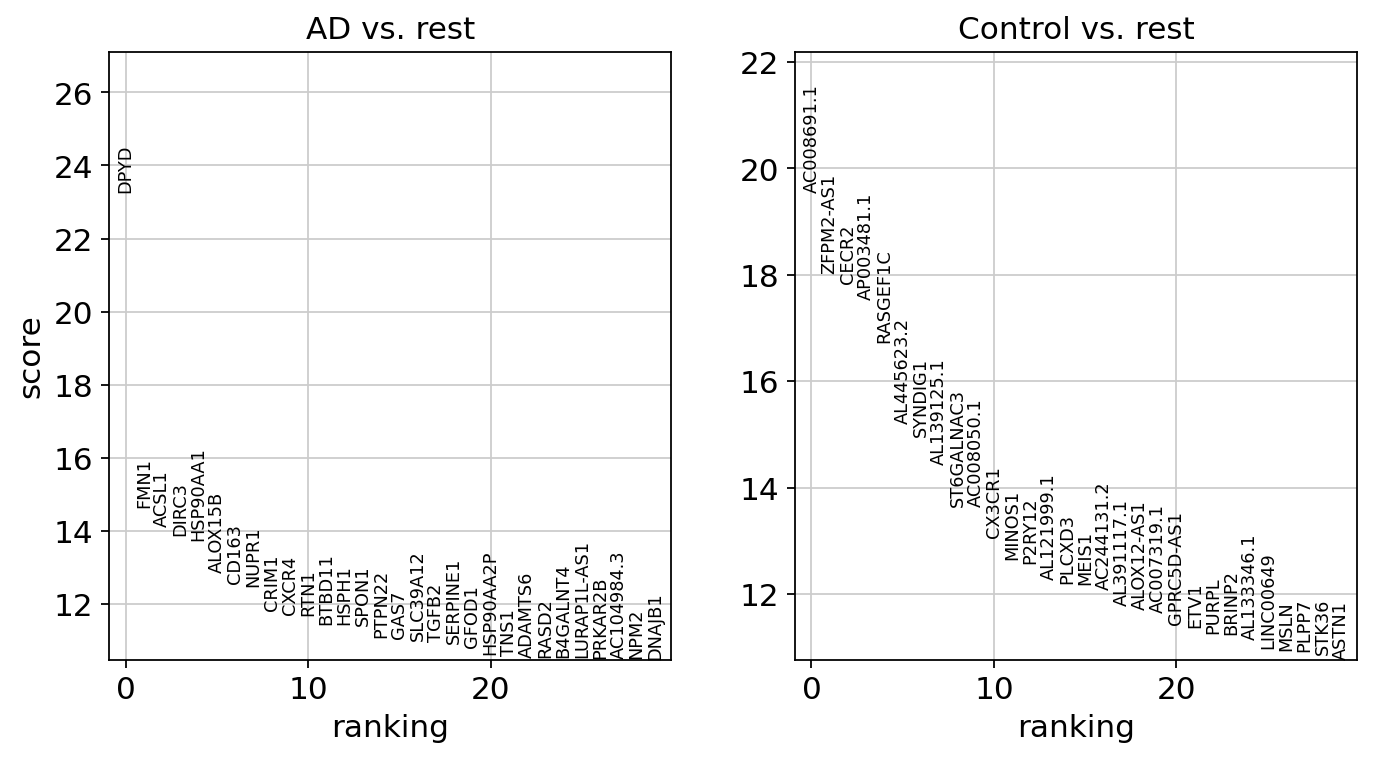

In [71]:
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

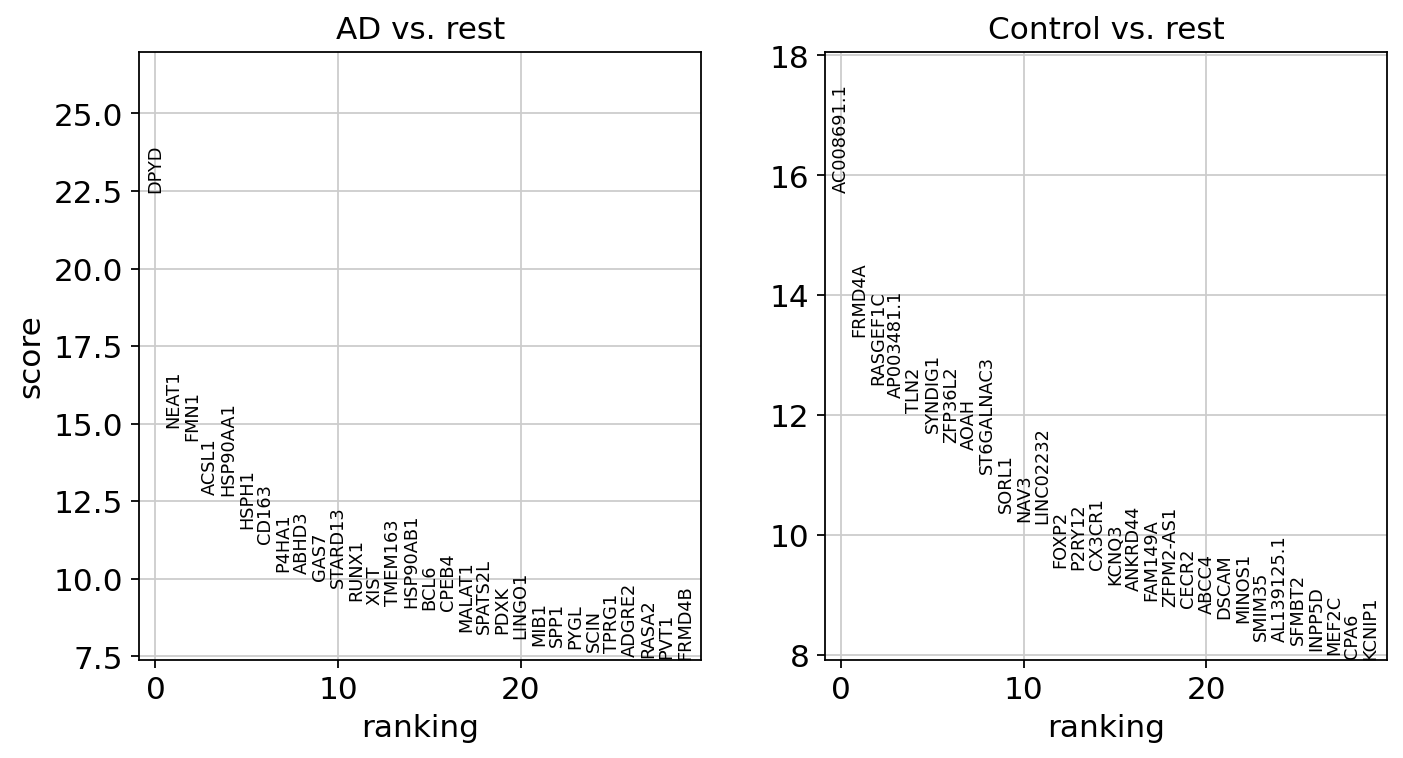

In [83]:
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='wilcoxon', use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

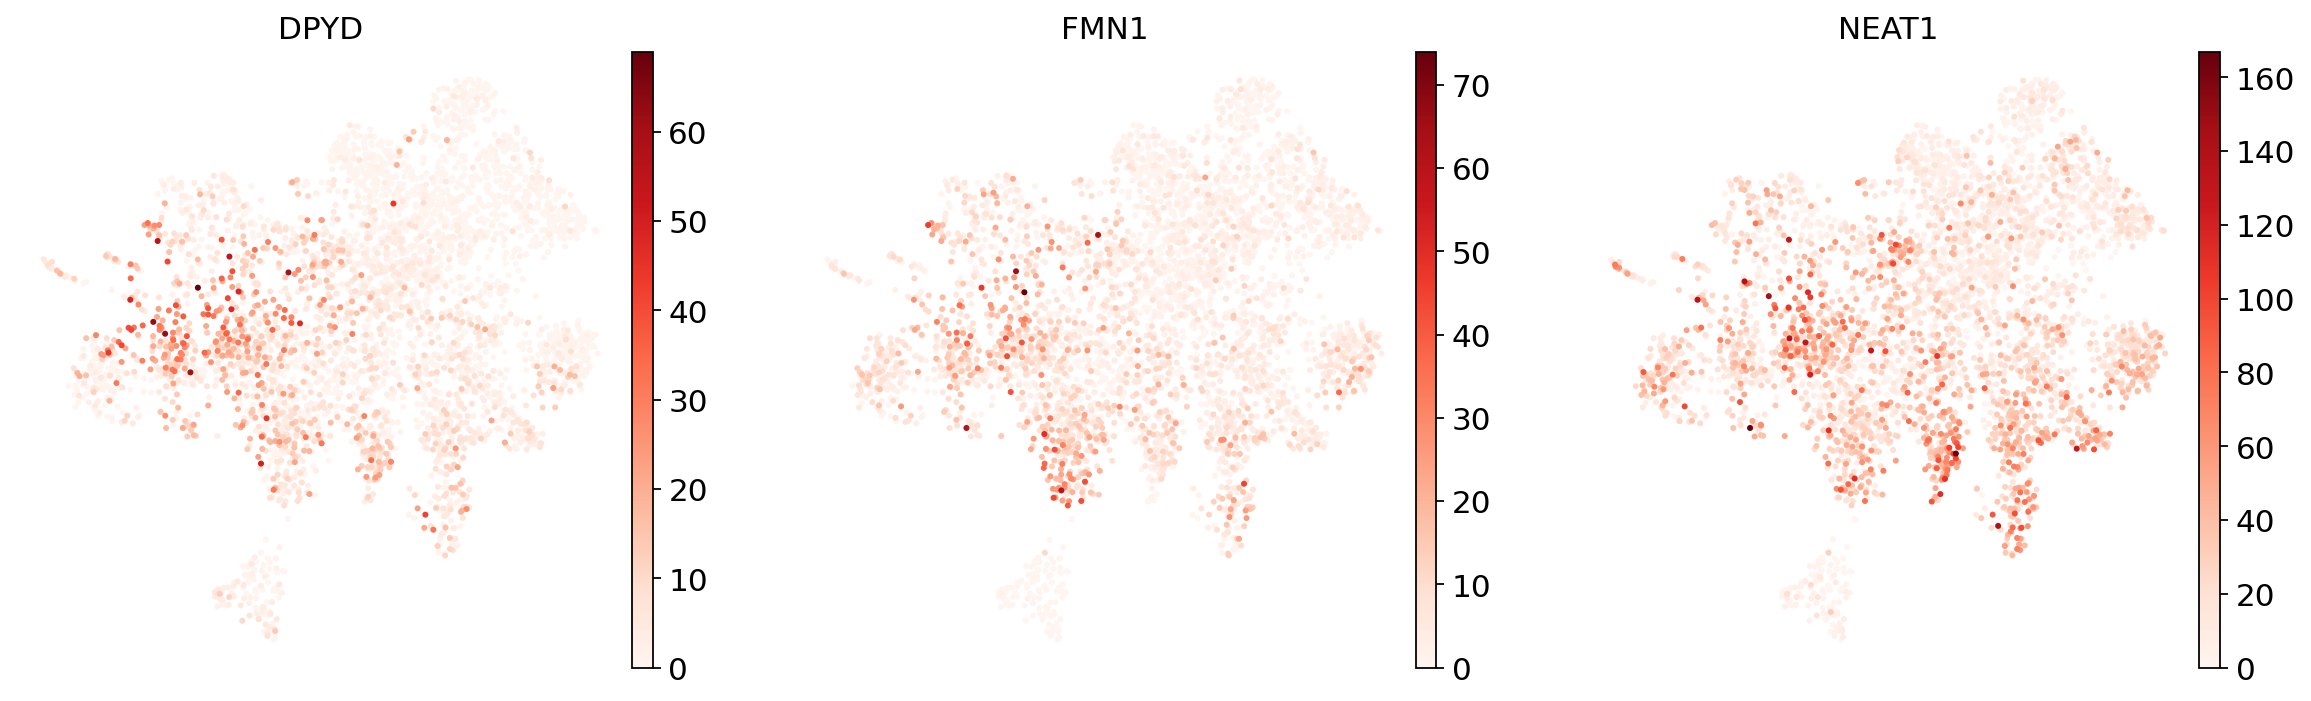

In [85]:
sc.pl.umap(adata, color=['DPYD', 'FMN1', 'NEAT1'], palette="Set2", color_map=mpl.cm.Reds)

# Saving the data

In [50]:
mg_state = os.path.join(os.getenv('VSC_SCRATCH'), 'mg_state')

In [56]:
adata.raw.to_adata().write(os.path.join(mg_state, 'alzheimers.raw.h5ad'), compression='gzip')
adata.write(os.path.join(mg_state, 'alzheimers.h5ad'), compression='gzip') 

# Loading data

In [ ]:
adata = sc.read_h5ad(os.path.join(mg_state, 'alzheimers.h5ad'))
adata.obs.head()

# ATAC-seq data

In [57]:
atac_metadata = pd.read_csv(os.path.join(atacseq_dir, 'snATAC_metadta.csv'), sep=',') #.iloc[:, -1].values
atac_metadata.index = atac_metadata.iloc[:,0]
atac_metadata = atac_metadata.rename(columns={'Unnamed: 0': 'barcode'})
atac_metadata['sample_id'] = 'alzheimers'
atac_metadata['celltype'] = atac_metadata['celltype'].astype(str)
atac_metadata

,barcode,Sample.ID,Batch,Sex,Age,Diagnosis,UMAP_1,UMAP_2,cluster,celltype,sample_id
Unnamed: 0,,,,,,,,,,,
AAACGAAAGAAACGCC-13,AAACGAAAGAAACGCC-13,Sample-96,1,M,79,Control,4.653650,-2.973710,ODC.f,ODC,alzheimers
AAACGAAAGAAATGGG-11,AAACGAAAGAAATGGG-11,Sample-101,2,F,74,Control,6.781233,-2.420259,ODC.k,ODC,alzheimers
AAACGAAAGAAATGGG-5,AAACGAAAGAAATGGG-5,Sample-37,3,F,87,AD,-2.631755,-6.038205,PER.END.a,PER.END,alzheimers
AAACGAAAGAAATTCG-13,AAACGAAAGAAATTCG-13,Sample-96,1,M,79,Control,-7.145253,2.478923,EX.b,EX,alzheimers
AAACGAAAGAACGACC-8,AAACGAAAGAACGACC-8,Sample-43,1,F,90,AD,3.383448,0.103595,ODC.a,ODC,alzheimers
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCTTCATAC-13,TTTGTGTTCTTCATAC-13,Sample-96,1,M,79,Control,6.218156,-2.558979,ODC.j,ODC,alzheimers
TTTGTGTTCTTCCACG-13,TTTGTGTTCTTCCACG-13,Sample-96,1,M,79,Control,4.888400,-5.111481,ODC.e,ODC,alzheimers
TTTGTGTTCTTCCACG-7,TTTGTGTTCTTCCACG-7,Sample-46,2,M,90,AD,6.508900,0.919111,ODC.b,ODC,alzheimers


In [86]:
atac_metadata = atac_metadata[atac_metadata.celltype == 'MG']
pickle.dump(atac_metadata, open(os.path.join(mg_state, 'atac_metadata.pkl'), 'wb'))
atac_metadata

,barcode,Sample.ID,Batch,Sex,Age,Diagnosis,UMAP_1,UMAP_2,cluster,celltype,sample_id
Unnamed: 0,,,,,,,,,,,
AAACGAAAGATGGCAC-1,AAACGAAAGATGGCAC-1,Sample-82,2,M,79,Control,-4.841460,-9.458201,MG.c,MG,alzheimers
AAACGAAAGGCTTAAA-13,AAACGAAAGGCTTAAA-13,Sample-96,1,M,79,Control,-2.296933,-8.279866,MG.d,MG,alzheimers
AAACGAAAGGGTAATT-16,AAACGAAAGGGTAATT-16,Sample-17,3,F,90,AD,-6.630811,-11.175748,MG.b,MG,alzheimers
AAACGAAAGGTCTTGT-7,AAACGAAAGGTCTTGT-7,Sample-46,2,M,90,AD,-7.044454,-10.177819,MG.a,MG,alzheimers
AAACGAAAGTAGAAGG-13,AAACGAAAGTAGAAGG-13,Sample-96,1,M,79,Control,-7.139698,-10.864028,MG.a,MG,alzheimers
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCACGTGTA-6,TTTGTGTTCACGTGTA-6,Sample-90,3,F,79,Control,-6.164500,-9.504558,MG.b,MG,alzheimers
TTTGTGTTCAGTCACA-3,TTTGTGTTCAGTCACA-3,Sample-58,3,M,90,Control,-4.807423,-9.474805,MG.c,MG,alzheimers
TTTGTGTTCGGTTAGT-16,TTTGTGTTCGGTTAGT-16,Sample-17,3,F,90,AD,-7.432466,-10.830232,MG.a,MG,alzheimers


In [63]:
fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}

In [61]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [87]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = atac_metadata,
                 variable = 'Diagnosis',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 1,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(mg_state, 'mg_rayspill'),
                 use_polars = False,
                 split_pattern = '-')

2022-11-11 22:42:08,361 cisTopic     INFO     Reading fragments from /data/leuven/345/vsc34561/ibp-2022-data/sn_atac_seq/fragments.tsv.gz
2022-11-11 23:26:00,552 cisTopic     INFO     Creating pseudobulk for AD
2022-11-11 23:43:46,742 cisTopic     INFO     AD done!
2022-11-11 23:43:46,751 cisTopic     INFO     Creating pseudobulk for Control
2022-11-11 23:54:49,420 cisTopic     INFO     Control done!


In [88]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [ ]:
import pickle
bed_paths = pickle.load(open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))

In [93]:
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(mg_state, 'consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=1,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(mg_state, 'mg_rayspill'))

2022-11-12 00:14:19,232 cisTopic     INFO     Calling peaks for AD with /data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2 callpeak --treatment /scratch/leuven/338/vsc33838/mg_state/consensus_peak_calling/pseudobulk_bed_files/AD.bed.gz --name AD  --outdir /scratch/leuven/338/vsc33838/mg_state/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2022-11-12 00:17:14,182 cisTopic     INFO     AD done!
2022-11-12 00:17:14,184 cisTopic     INFO     Calling peaks for Control with /data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2 callpeak --treatment /scratch/leuven/338/vsc33838/mg_state/consensus_peak_calling/pseudobulk_bed_files/Control.bed.gz --name Control  --outdir /scratch/leuven/338/vsc33838/mg_state/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2022-11-12 00:18:51,984 

In [94]:
narrow_peaks_dict

{'AD': +--------------+-----------+-----------+----------------+-----------+-------+
 | Chromosome   | Start     | End       | Name           | Score     | +5    |
 | (category)   | (int32)   | (int32)   | (object)       | (int64)   | ...   |
 |--------------+-----------+-----------+----------------+-----------+-------|
 | chr1         | 191401    | 191569    | AD_peak_1      | 128       | ...   |
 | chr1         | 778303    | 779709    | AD_peak_2a     | 1033      | ...   |
 | chr1         | 778303    | 779709    | AD_peak_2b     | 745       | ...   |
 | chr1         | 816876    | 817556    | AD_peak_3      | 919       | ...   |
 | ...          | ...       | ...       | ...            | ...       | ...   |
 | chrY         | 56851196  | 56851456  | AD_peak_105663 | 22        | ...   |
 | chrY         | 56857935  | 56858181  | AD_peak_105664 | 22        | ...   |
 | chrY         | 56861429  | 56861606  | AD_peak_105665 | 22        | ...   |
 | chrY         | 56870896  | 56871150  | AD_p

In [95]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(mg_state, 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [96]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2022-11-12 00:18:52,566 cisTopic     INFO     Extending and merging peaks per class
2022-11-12 00:19:28,442 cisTopic     INFO     Normalizing peak scores
2022-11-12 00:19:28,558 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-11-12 00:20:04,711 cisTopic     INFO     Done!


In [97]:
consensus_peaks.to_bed(
    path = os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

# ATAC-seq quality control

In [113]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'alzheimers':os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                use_polars = False,
                _temp_dir = os.path.join(mg_state, 'mg_rayspill'))

if not os.path.exists(os.path.join(mg_state, 'quality_control')):
    os.makedirs(os.path.join(mg_state, 'quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(mg_state, 'quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(mg_state, 'quality_control/profile_data_dict.pkl'), 'wb'))

2022-11-12 00:50:03,489 cisTopic     INFO     Reading alzheimers
2022-11-12 01:07:19,457 cisTopic     INFO     Computing barcode rank plot for alzheimers
2022-11-12 01:07:19,460 cisTopic     INFO     Counting fragments
2022-11-12 01:08:36,761 cisTopic     INFO     Marking barcodes with more than 100
2022-11-12 01:08:37,108 cisTopic     INFO     Returning plot data
2022-11-12 01:08:37,200 cisTopic     INFO     Returning valid barcodes
2022-11-12 01:09:32,118 cisTopic     INFO     Computing duplicate rate plot for alzheimers
2022-11-12 01:11:14,816 cisTopic     INFO     Return plot data
2022-11-12 01:11:15,199 cisTopic     INFO     Computing insert size distribution for alzheimers
2022-11-12 01:11:15,201 cisTopic     INFO     Counting fragments
2022-11-12 01:11:33,087 cisTopic     INFO     Returning plot data
2022-11-12 01:17:19,565 cisTopic     INFO     Computing TSS profile for alzheimers
2022-11-12 01:19:25,417 cisTopic     INFO     Formatting annnotation
2022-11-12 01:19:25,507 cisTo

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

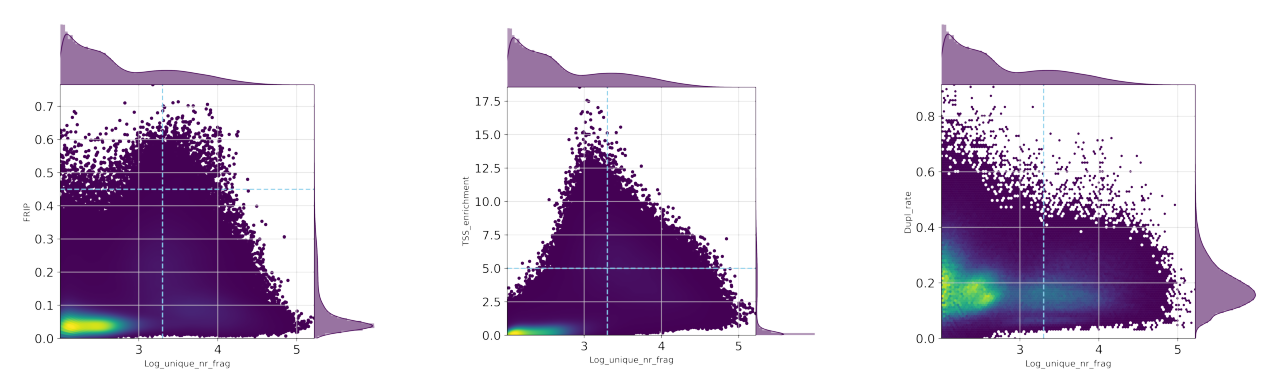

In [114]:
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [115]:
bc_passing_filters = {'alzheimers':[]}
bc_passing_filters['alzheimers'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters, open(os.path.join(mg_state, 'quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['alzheimers'])} barcodes passed QC stats")

1708 barcodes passed QC stats


# Checkpoint load

In [3]:
# Load if needed
mg_state = os.path.join(os.getenv('VSC_SCRATCH'), 'mg_state')
fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}
adata = sc.read_h5ad(os.path.join(mg_state, 'alzheimers.h5ad'))
path_to_regions = {'alzheimers':os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
metadata_bc = pickle.load(open(os.path.join(mg_state, 'quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(mg_state, 'quality_control/bc_passing_filters.pkl'), 'rb'))
atac_metadata = pickle.load(open(os.path.join(mg_state, 'atac_metadata.pkl'), 'rb'))



In [4]:
cell_data = adata.obs
cell_data['sample_id'] = 'alzheimers'
cell_data['celltype'] = cell_data['celltype'].astype(str)

# Topic Modelling

In [5]:
metadata_bc['alzheimers']

,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,Dupl_rate,Total_nr_frag_in_regions,Unique_nr_frag_in_regions,FRIP,TSS_enrichment
ACTTTCACAAGCAACG-13,3.930185,3.900586,8515,7954,561,0.065884,671,627,0.078828,2.518127
AGGACGAGTGGACAGT-14,3.626853,3.573684,4235,3747,488,0.115230,1518,1336,0.356552,5.597534
TAATTCCAGAACTCCT-14,3.472464,3.418301,2968,2620,348,0.117251,756,649,0.247710,5.288406
TCCCACACAACTACTG-14,3.621799,3.567026,4186,3690,496,0.118490,1118,976,0.264499,6.094288
CAGCTAAAGGGTCCCT-14,3.980458,3.929061,9560,8493,1067,0.111611,2044,1797,0.211586,3.671378
...,...,...,...,...,...,...,...,...,...,...
TCGCAGGAGACACTTC-8,2.110590,2.056905,129,114,15,0.116279,7,5,0.043860,0.155000
ACAATCGAGCGTCAAG-12,2.139879,2.037426,138,109,29,0.210145,6,4,0.036697,0.000000
CTTAATCGTAACGGCA-20,2.252853,2.045323,179,111,68,0.379888,9,7,0.063063,0.000000
GTCACCTCAGAGATGC-14,2.158362,2.071882,144,118,26,0.180556,3,3,0.025424,0.050000


In [118]:
from pycisTopic.cistopic_class import *

key = 'alzheimers'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key])),
                            n_cpu=30,
                            project=key,
                            split_pattern='-')


2022-11-12 05:00:52,013 cisTopic     INFO     Reading data for alzheimers
2022-11-12 05:17:46,328 cisTopic     INFO     metrics provided!
2022-11-12 05:18:59,383 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-11-12 05:19:27,275 cisTopic     INFO     Counting fragments in regions


2022-11-12 05:19:41,276	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2022-11-12 05:22:17,231 cisTopic     INFO     Creating fragment matrix
2022-11-12 05:22:26,101 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-11-12 05:22:27,399 cisTopic     INFO     Removing blacklisted regions
2022-11-12 05:22:28,017 cisTopic     INFO     Creating CistopicObject
2022-11-12 05:22:28,391 cisTopic     INFO     Done!


In [121]:
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,6,10,16],
                    n_cpu=5,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = '/tmp/rayspill')

2022-11-12 10:06:14,806	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(run_cgs_model pid=1470216) 2022-11-12 10:06:21,851 cisTopic     INFO     Running model with 6 topics
(run_cgs_model pid=1470215) 2022-11-12 10:06:21,851 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=1470217) 2022-11-12 10:06:21,851 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=1470219) 2022-11-12 10:06:21,849 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=1470214) 2022-11-12 10:06:21,853 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=1470215) 2022-11-12 10:08:19,997 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=1470219) 2022-11-12 10:09:20,978 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=1470216) 2022-11-12 10:10:21,380 cisTopic     INFO     Model with 6 topics done!
(run_cgs_model pid=1470217) 2022-11-12 10:12:04,437 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=1470214) 2022-11-12 10:14:25,212 cisTopic     INFO     Model with 16

In [122]:
if not os.path.exists(os.path.join(mg_state, 'models')):
    os.makedirs(os.path.join(mg_state, 'models'))

pickle.dump(models, open(os.path.join(mg_state, 'models/alzheimers_topics.pkl'), 'wb'))

In [ ]:
models = pickle.load(open(os.path.join(mg_state, 'models/alzheimers_topics.pkl'), 'rb'))

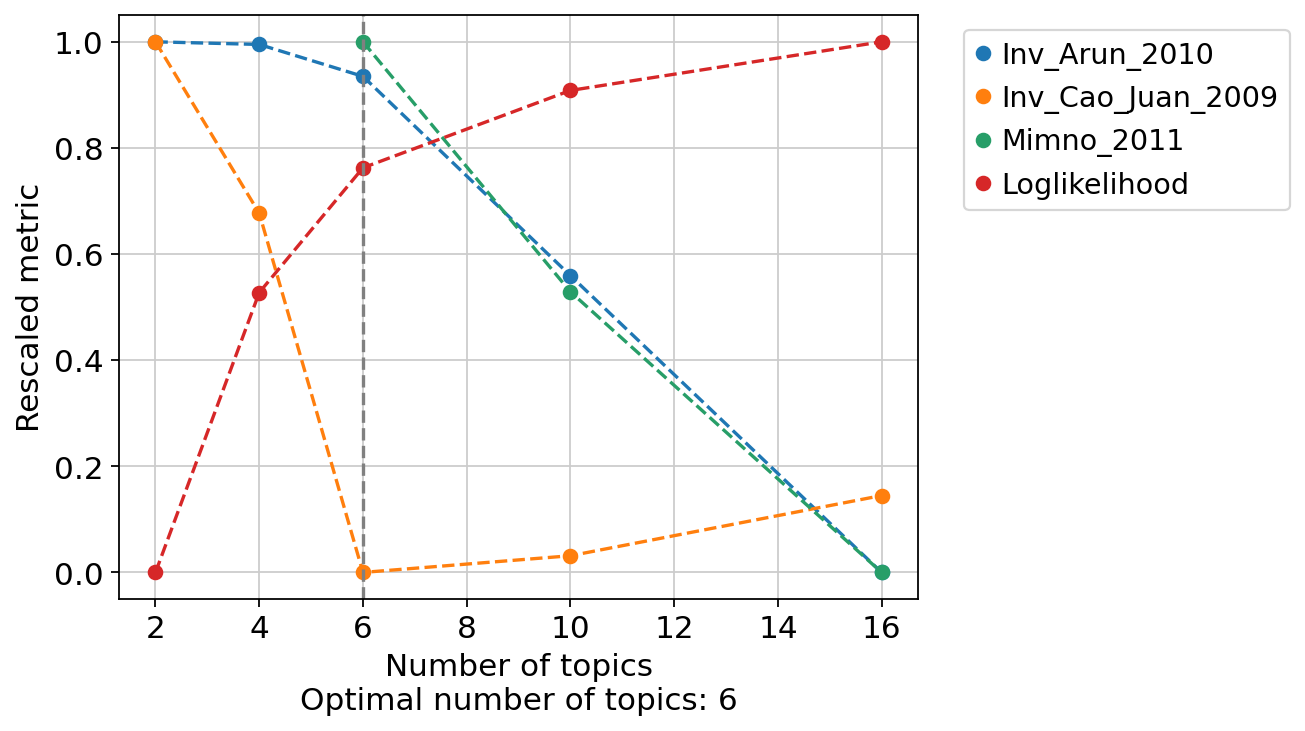

In [124]:
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=6,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)


In [125]:
cistopic_obj.add_cell_data(atac_metadata, split_pattern='-')
cistopic_obj.add_LDA_model(model)

pickle.dump(cistopic_obj, open(os.path.join(mg_state, 'cistopic_obj.pkl'), 'wb'))

Columns ['barcode', 'sample_id'] will be overwritten


# Visualization of topic modelling

In [7]:
cistopic_obj = pickle.load(open(os.path.join(mg_state, 'cistopic_obj.pkl'), 'rb'))

In [10]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)

2022-11-12 11:18:11,470 cisTopic     INFO     Running UMAP


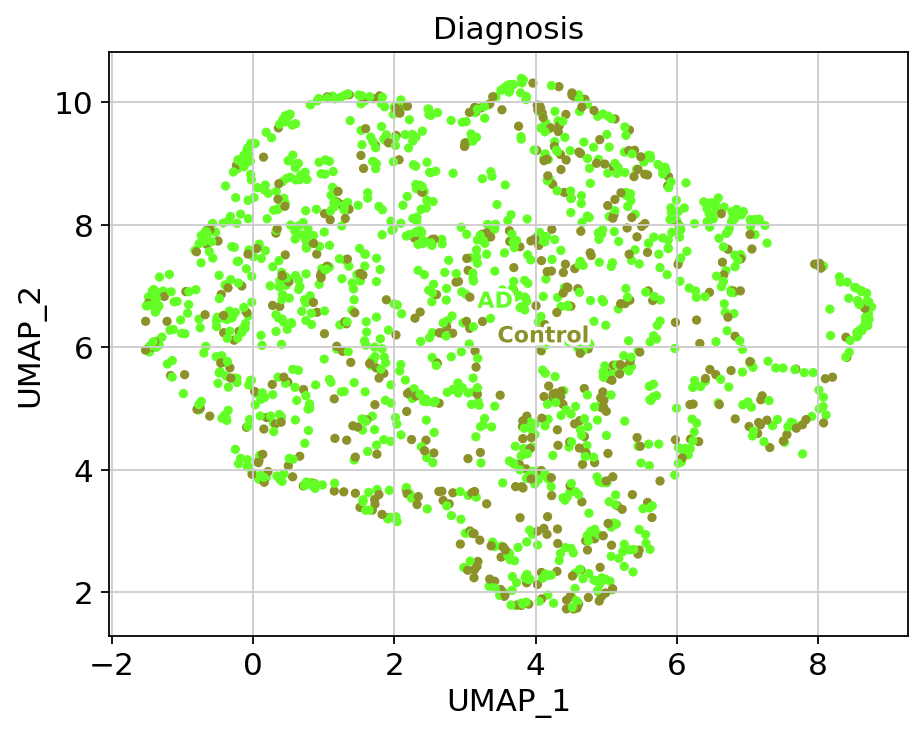

In [11]:
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['Diagnosis'])

Here we do the same plot using the UMAP coordinates in the metadata.

In [142]:
cmap = {'AD': 'red', 
        'Control': 'green'}

na_mask = cistopic_obj.cell_data['Diagnosis'].isna() == False

for diag in cmap.keys():
    cmask = (cistopic_obj.cell_data['Diagnosis'] == diag) & na_mask
    mpl.pyplot.scatter(cistopic_obj.cell_data[cmask]['UMAP_1'].values, 
                    cistopic_obj.cell_data[cmask]['UMAP_2'].values,
                    label=diag,
                    color=cmap[diag])
mpl.pyplot.legend()

In [ ]:
# plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 3)

# Inferring candidate enhancer regions

In [15]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 512x384 with 0 Axes>

<Figure size 512x384 with 0 Axes>

In [16]:
region_bin_topics_top3k

{'Topic1':                             Topic1
 chr10:48582957-48583457   0.001667
 chr3:72523305-72523805    0.001488
 chr12:41932435-41932935   0.001430
 chr7:114085443-114085943  0.001404
 chr6:149246663-149247163  0.001392
 ...                            ...
 chr7:131859152-131859652  0.000267
 chr4:112523775-112524275  0.000267
 chr3:52197839-52198339    0.000267
 chr2:126644737-126645237  0.000267
 chr7:55365261-55365761    0.000267
 
 [2998 rows x 1 columns],
 'Topic2':                              Topic2
 chr1:24744974-24745474     0.002079
 chr6:31827207-31827707     0.002038
 chr7:30284196-30284696     0.001995
 chr5:41903801-41904301     0.001911
 chr4:128060997-128061497   0.001880
 ...                             ...
 chr13:114282013-114282513  0.000314
 chr12:106147985-106148485  0.000314
 chr22:37608344-37608844    0.000314
 chr17:17836152-17836652    0.000314
 chr3:38136967-38137467     0.000314
 
 [3000 rows x 1 columns],
 'Topic3':                              Topic3
 

In [17]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='Diagnosis', var_features=variable_regions, split_pattern = '-')

2022-11-12 20:05:09,423 cisTopic     INFO     Imputing drop-outs
2022-11-12 20:05:09,810 cisTopic     INFO     Scaling
2022-11-12 20:05:10,354 cisTopic     INFO     Keep non zero rows
2022-11-12 20:05:10,956 cisTopic     INFO     Imputed accessibility sparsity: 0.08380111221762399
2022-11-12 20:05:10,957 cisTopic     INFO     Create CistopicImputedFeatures object
2022-11-12 20:05:10,958 cisTopic     INFO     Done!
2022-11-12 20:05:10,959 cisTopic     INFO     Normalizing imputed data
2022-11-12 20:05:13,152 cisTopic     INFO     Done!
2022-11-12 20:05:13,153 cisTopic     INFO     Calculating mean
2022-11-12 20:05:13,397 cisTopic     INFO     Calculating variance
2022-11-12 20:05:16,731 cisTopic     INFO     Done!
2022-11-12 20:05:17,034 cisTopic     INFO     Formatting data for AD
2022-11-12 20:05:17,572 cisTopic     INFO     Computing p-value for AD
2022-11-12 20:05:46,698 cisTopic     INFO     Computing log2FC for AD
2022-11-12 20:05:47,698 cisTopic     INFO     AD done!
2022-11-12 2

<Figure size 400x400 with 0 Axes>

In [18]:
if not os.path.exists(os.path.join(mg_state, 'candidate_enhancers')):
    os.makedirs(os.path.join(mg_state, 'candidate_enhancers'))

pickle.dump(region_bin_topics_otsu, open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(mg_state, 'candidate_enhancers/markers_dict.pkl'), 'wb'))

# Loading checkpoints

In [ ]:
region_bin_topics_otsu = pickle.load(open(os.path.join(state_dir, 'candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(state_dir, 'candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(state_dir, 'candidate_enhancers/markers_dict.pkl'), 'rb'))

# PycisTarget

In [19]:
markers_dict

{'AD': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 'Control': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: []}

In [20]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
# region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
# for DAR in markers_dict.keys():
#     regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
#     region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [21]:
db_fpath = '/data/leuven/338/vsc33838/mirror/motifs'
rankings_db = os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(db_fpath, 'motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl')

In [22]:
if not os.path.exists(os.path.join(mg_state, 'motifs')):
    os.makedirs(os.path.join(mg_state, 'motifs'))

from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(mg_state, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 30,
    _temp_dir = '/tmp/ray_spill2',
    annotation_version = 'v10nr_clust',
    )

2022-11-12 20:06:19,147 pycisTarget_wrapper INFO     /scratch/leuven/338/vsc33838/mg_state/motifs folder already exists.
2022-11-12 20:06:19,639 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2022-11-12 20:06:19,641 cisTarget    INFO     Reading cisTarget database
2022-11-12 20:10:49,183 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu


2022-11-12 20:10:54,887	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=1547169) 2022-11-12 20:11:10,533 cisTarget    INFO     Running cisTarget for Topic1 which has 6821 regions
(ctx_internal_ray pid=1547187) 2022-11-12 20:11:10,529 cisTarget    INFO     Running cisTarget for Topic2 which has 5018 regions
(ctx_internal_ray pid=1547188) 2022-11-12 20:11:10,729 cisTarget    INFO     Running cisTarget for Topic3 which has 6867 regions
(ctx_internal_ray pid=1547186) 2022-11-12 20:11:10,995 cisTarget    INFO     Running cisTarget for Topic4 which has 4900 regions
(ctx_internal_ray pid=1547179) 2022-11-12 20:11:11,163 cisTarget    INFO     Running cisTarget for Topic5 which has 6478 regions
(ctx_internal_ray pid=1547185) 2022-11-12 20:11:11,344 cisTarget    INFO     Running cisTarget for Topic6 which has 7252 regions
(ctx_internal_ray pid=1547187) 2022-11-12 20:11:27,936 cisTarget    INFO     Annotating motifs for Topic2
(ctx_internal_ray pid=1547188) 2022-11-12 20:11:28,363 cisTarget    INFO     Annotating motifs for Topic3
(ctx_internal_

2022-11-12 20:11:47,241	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=1549339) 2022-11-12 20:12:04,624 cisTarget    INFO     Running cisTarget for Topic1 which has 4895 regions
(ctx_internal_ray pid=1549342) 2022-11-12 20:12:04,740 cisTarget    INFO     Running cisTarget for Topic2 which has 1418 regions
(ctx_internal_ray pid=1549350) 2022-11-12 20:12:04,936 cisTarget    INFO     Running cisTarget for Topic3 which has 4967 regions
(ctx_internal_ray pid=1549359) 2022-11-12 20:12:05,232 cisTarget    INFO     Running cisTarget for Topic4 which has 688 regions
(ctx_internal_ray pid=1549348) 2022-11-12 20:12:05,471 cisTarget    INFO     Running cisTarget for Topic5 which has 3924 regions
(ctx_internal_ray pid=1549351) 2022-11-12 20:12:05,815 cisTarget    INFO     Running cisTarget for Topic6 which has 4800 regions
(ctx_internal_ray pid=1549339) 2022-11-12 20:12:20,962 cisTarget    INFO     Annotating motifs for Topic1
(ctx_internal_ray pid=1549342) 2022-11-12 20:12:21,762 cisTarget    INFO     Annotating motifs for Topic2
(ctx_internal_r

2022-11-12 20:16:52,848	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1552065) 2022-11-12 20:17:02,907 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1552064) 2022-11-12 20:17:03,131 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1552067) 2022-11-12 20:17:03,233 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=1552066) 2022-11-12 20:17:03,266 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1552063) 2022-11-12 20:17:03,432 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=1552061) 2022-11-12 20:17:03,776 DEM          INFO     Computing DEM for Topic6
2022-11-12 20:17:38,940 DEM          INFO     Forming cistromes
2022-11-12 20:17:39,937 DEM          INFO     Done!
2022-11-12 20:17:40,633 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/mg_state/motifs/DEM_topics_otsu_All
2022-11-12 20:17:40,695 pycisTarget_wrapper INFO     Running DEM without promoters for topics_otsu
2022-11-12 20:17:44,632 DEM          I

2022-11-12 20:17:50,467	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1552526) 2022-11-12 20:17:59,353 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1552525) 2022-11-12 20:17:59,667 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1552524) 2022-11-12 20:17:59,752 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=1552522) 2022-11-12 20:18:00,259 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1552523) 2022-11-12 20:18:00,476 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=1552521) 2022-11-12 20:18:00,715 DEM          INFO     Computing DEM for Topic6
2022-11-12 20:18:12,630 DEM          INFO     Forming cistromes
2022-11-12 20:18:13,672 DEM          INFO     Done!
2022-11-12 20:18:14,317 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/mg_state/motifs/DEM_topics_otsu_No_promoters
2022-11-12 20:18:14,398 pycisTarget_wrapper INFO     Loading cisTarget database for topics_top_3
2022-11-12 20:18:14,400 cisTarg

2022-11-12 20:19:00,008	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


(ctx_internal_ray pid=1553556) 2022-11-12 20:19:14,510 cisTarget    INFO     Running cisTarget for Topic2 which has 3967 regions
(ctx_internal_ray pid=1553551) 2022-11-12 20:19:14,497 cisTarget    INFO     Running cisTarget for Topic1 which has 3483 regions
(ctx_internal_ray pid=1553540) 2022-11-12 20:19:14,670 cisTarget    INFO     Running cisTarget for Topic3 which has 3525 regions
(ctx_internal_ray pid=1553544) 2022-11-12 20:19:14,914 cisTarget    INFO     Running cisTarget for Topic4 which has 3902 regions
(ctx_internal_ray pid=1553549) 2022-11-12 20:19:14,975 cisTarget    INFO     Running cisTarget for Topic5 which has 3652 regions
(ctx_internal_ray pid=1553538) 2022-11-12 20:19:15,115 cisTarget    INFO     Running cisTarget for Topic6 which has 3679 regions
(ctx_internal_ray pid=1553540) 2022-11-12 20:19:31,328 cisTarget    INFO     Annotating motifs for Topic3
(ctx_internal_ray pid=1553544) 2022-11-12 20:19:31,359 cisTarget    INFO     Annotating motifs for Topic4
(ctx_internal_

2022-11-12 20:19:47,931	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


(ctx_internal_ray pid=1554658) 2022-11-12 20:20:02,694 cisTarget    INFO     Running cisTarget for Topic2 which has 992 regions
(ctx_internal_ray pid=1554650) 2022-11-12 20:20:02,695 cisTarget    INFO     Running cisTarget for Topic1 which has 2437 regions
(ctx_internal_ray pid=1554642) 2022-11-12 20:20:02,768 cisTarget    INFO     Running cisTarget for Topic3 which has 2500 regions
(ctx_internal_ray pid=1554652) 2022-11-12 20:20:02,914 cisTarget    INFO     Running cisTarget for Topic4 which has 472 regions
(ctx_internal_ray pid=1554659) 2022-11-12 20:20:02,945 cisTarget    INFO     Running cisTarget for Topic5 which has 2106 regions
(ctx_internal_ray pid=1554661) 2022-11-12 20:20:03,051 cisTarget    INFO     Running cisTarget for Topic6 which has 2413 regions
(ctx_internal_ray pid=1554661) 2022-11-12 20:20:19,339 cisTarget    INFO     Annotating motifs for Topic6
(ctx_internal_ray pid=1554652) 2022-11-12 20:20:19,890 cisTarget    INFO     Annotating motifs for Topic4
(ctx_internal_ra

2022-11-12 20:21:21,318	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1556445) 2022-11-12 20:21:30,869 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=1556446) 2022-11-12 20:21:30,970 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1556441) 2022-11-12 20:21:31,105 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1556442) 2022-11-12 20:21:31,275 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1556443) 2022-11-12 20:21:31,285 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=1556444) 2022-11-12 20:21:31,368 DEM          INFO     Computing DEM for Topic6
2022-11-12 20:21:57,631 DEM          INFO     Forming cistromes
2022-11-12 20:21:58,610 DEM          INFO     Done!
2022-11-12 20:21:59,049 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/mg_state/motifs/DEM_topics_top_3_All
2022-11-12 20:21:59,119 pycisTarget_wrapper INFO     Running DEM without promoters for topics_top_3
2022-11-12 20:22:01,613 DEM         

2022-11-12 20:22:06,993	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1556925) 2022-11-12 20:22:16,833 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1556922) 2022-11-12 20:22:16,850 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1556927) 2022-11-12 20:22:16,915 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=1556926) 2022-11-12 20:22:17,112 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1556924) 2022-11-12 20:22:17,226 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=1556923) 2022-11-12 20:22:17,349 DEM          INFO     Computing DEM for Topic6
2022-11-12 20:22:28,918 DEM          INFO     Forming cistromes
2022-11-12 20:22:29,863 DEM          INFO     Done!
2022-11-12 20:22:30,264 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/mg_state/motifs/DEM_topics_top_3_No_promoters
2022-11-12 20:22:30,331 pycisTarget_wrapper INFO     Saving object
2022-11-12 20:25:29,851 pycisTarget_wrapper INFO     Finishe

In [26]:
import dill
menr = dill.load(open(os.path.join(os.path.join(mg_state, 'motifs'), 'menr.pkl'), 'rb'))

In [27]:
menr['DEM_topics_otsu_All'].DEM_results('Topic2')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
metacluster_111.3,,Topic2,"ATF1, ATF3, E4F1, CREM, CREB1","JDP2, CREB1, CREM",0.630253,0.01252,0.919952,0.594347,3.0,482.0
taipale_cyt_meth__ZNF449_RCGCCCAACC_eDBD_repr,,Topic2,ZNF449,NaN,0.620248,0.005269,0.452879,0.294624,3.0,164.0
metacluster_3.8,,Topic2,NaN,SP5,0.540371,0.000039,1.960665,1.348142,3.0,1274.0
metacluster_111.4,,Topic2,"ATF1, JUN, ZNF629, FOSL1, ATF6B, CREB1, CREB3L4, ATF3, ATF7, CREB5, BATF3, CREM, ATF4, FOSL2, FOSB, ATF2, JUND, JDP2, JUNB, XBP1, ATF5, ATF6, CREB3","BATF2, FOS, CREB3L1, ATF1, FOSL1, ATF6B, CREB1, BATF, CREB3L4, ATF3, ATF7, CREB3L3, BATF3, CREM, FOSL2, ATF7-NPFF, FOSB, ATF2, CREB3L2, JDP2, ATF6, CREB3",0.506652,0.037805,0.929818,0.654456,3.0,425.0
metacluster_111.5,,Topic2,E4F1,NaN,0.502741,0.01252,0.794636,0.560826,3.0,340.0
metacluster_144.3,,Topic2,ZNF704,NaN,0.500711,0.000047,0.575339,0.406626,3.0,130.0


In [28]:
menr['DEM_topics_otsu_All'].DEM_results('Topic3')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
jaspar__MA1956.1,,Topic3,FOXO1,NaN,0.702225,0.01354,0.466649,0.286813,3.0,379.0
tfdimers__MD00317,,Topic3,"TP73, TP63, MYB, TP53",NaN,0.658007,0.002788,0.665159,0.421547,3.0,459.0
jaspar__MA1954.1,,Topic3,FOXO1,NaN,0.581463,0.001647,0.972052,0.649609,3.0,803.0
tfdimers__MD00581,,Topic3,"ATF5, NKX3-2",NaN,0.574364,0.039605,0.737735,0.49545,3.0,648.0
tfdimers__MD00571,,Topic3,"HOXD10, ETS1",NaN,0.550544,0.035204,0.570186,0.389302,3.0,470.0
metacluster_26.2,,Topic3,ZNF264,NKX2-8,0.543558,0.014161,0.49381,0.338791,3.0,272.0
tfdimers__MD00530,,Topic3,"BACH1, MAFK, NFE2, MAFF, MAFG, NFE2L2, BACH2, NR3C1, MAF, NFE2L3, NFE2L1, MAFB",NaN,0.543495,0.018742,0.577011,0.395891,3.0,404.0
metacluster_122.8,,Topic3,NaN,PRDM7,0.532559,0.01862,0.674043,0.465984,3.0,490.0
tfdimers__MD00373,,Topic3,"STAT6, TBP, TAF6",NaN,0.513744,0.013691,1.048171,0.734142,3.0,934.0
jaspar__MA1953.1,,Topic3,FOXO1,NaN,0.50991,0.000091,1.050103,0.737452,3.0,809.0


In [29]:
menr['DEM_topics_otsu_All'].DEM_results('Topic4')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
metacluster_141.4,,Topic4,GLIS2,NaN,1.806138,0.0,0.539574,0.154294,3.0,445.0
taipale_cyt_meth__E2F2_GCGCGCGCGYW_eDBD_repr,,Topic4,E2F2,NaN,1.784817,0.0,0.634475,0.184133,3.0,338.0
taipale_cyt_meth__ZNF385D_NCGTCGCGACGN_eDBD_meth,,Topic4,ZNF385D,NaN,1.718263,0.0,0.297454,0.090401,3.0,108.0
dbtfbs__GMEB1_K562_ENCSR928KOR_merged_N1,,Topic4,GMEB1,NaN,1.715284,0.000057,0.465274,0.141696,3.0,248.0
transfac_pro__M05951,,Topic4,NaN,ZNF672,1.693529,0.002859,0.259597,0.08026,3.0,130.0
metacluster_55.3,,Topic4,"ZBTB2, E2F6, NRF1, ZSCAN10, EGR1","NFE2L1, NRF1",1.631747,0.0,1.27447,0.411268,3.0,769.0
transfac_pro__M06254,,Topic4,ZNF267,NaN,1.587044,0.004453,0.248147,0.082596,3.0,121.0
metacluster_81.7,,Topic4,CREB1,NaN,1.564605,0.0,0.379615,0.128337,3.0,195.0
kznf__ZNF777_Imbeault2017_OM_MEME,,Topic4,ZNF777,NaN,1.559337,0.0,0.318197,0.107967,3.0,287.0
taipale_tf_pairs__E2F1_EOMES_RGGTGTNNNGGCGSNNTNNCRSNN_CAP,,Topic4,"E2F1, EOMES",NaN,1.535014,0.004376,0.196426,0.067782,3.0,79.0


In [30]:
menr['DEM_topics_otsu_All'].DEM_results('Topic5')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits


In [31]:
menr['DEM_topics_otsu_All'].DEM_results('Topic6')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
